# EE4375: Fourth Lab Session: Finite Element Method for the Poisson Equation on the Unit Interval

The **goals** of this fourth lab session are three-fold. 

The **first** goal is to implement a Galerkin finite element method using linear Lagrange shape functions to solve the one-dimensional Poisson equation supplied with Dirichlet and Neumann boundary conditions. The boundary value problem we intend to solver in this lab session is exactly the same as the boundary value problem we already solved in the second lab session. The assembly and the solve of the linear system will be explored. In the assembly process, a contribution per element to the matrix and right-hand side vector and a loop over elements is employed. The term element here refers to the interval that extends between two nodes of the mesh. Similarly to the second and third lab session, a sparse direct solver is employed to solve the resulting linear system. Unlike in the second lab session, non-uniform meshes can be employed. 

The **second** goal is to compare the numerical solution obtained with an one-dimensional analytical reference solution. The same reference solutions as in the second lab session can be employed. 

The **third** goal is apply the one-dimensional finite element method to a coil-core-air configuration. 

This lab session complements the lecture slides [block2-finite-element-method-1d.pdf](https://github.com/ziolai/finite_element_electrical_engineering/blob/main/slides/block2-finite-element-method-1d.pdf) available at [EE4375 GitHub Directory](https://github.com/ziolai/finite_element_electrical_engineering/tree/main/slides).

## Import Packages  

In [1]:
using LinearAlgebra 
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1: Introduction  

Section 2 develops the FEM code as a script. This section uses a dense coefficient matrix and is mainly intended for illustration purposes. Section 3 introduces data structures and performs mesh generation. Section 4 assembles the linear system, i.e., the coefficient matrix and the right-hand side vector. Section 5 solves the linear system. 

## Section 2: Script Version
The script version allows for easy experimentation. 

To do: 
1. extend with comparison with analytical solution (plot of absolute error on semilogy axis, plot of max of error vs. mesh width);
2. extend with comparison of numerically and analytically computed derivative of the solution $du/dx$; 
3. implement homogeneous and non-homogeneous Neumann boundary conditions; 

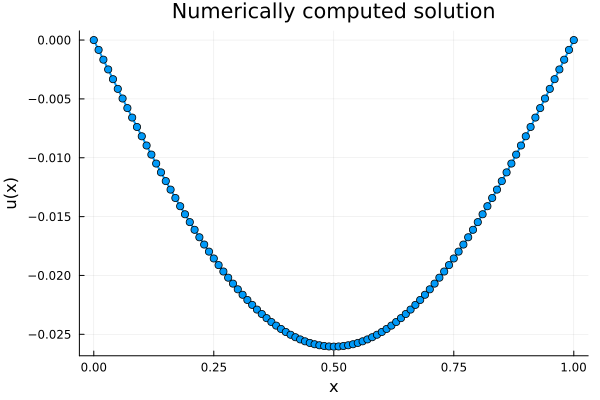

In [2]:
#..construct the mesh: see before 
nelements = 100; nnodes = nelements+1; h = 1/nelements
x = Vector(0:h:1)

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:nelements) 
edges = collect( [i, i+1] for i in 1:nelements) 

#..Set the source function 
fsource(x) = x*(x-1)

#..Initialize local and global matrix and right-hand side value 
floc = zeros(Float64,2, 1)
Aloc = zeros(Float64,2,2)
A = zeros(Float64,nnodes, nnodes)
f = zeros(Float64,nnodes)  

#..Perform loop over elements and assemble global matrix and vector 
for i=1:nelements 

  xl, xr = points[i,:][1]
  floc = (xr-xl)/2 * [fsource(xl), fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  for j=1:2 
    f[edges[i][j]] += floc[j]
    for k =1:2 
      A[edges[i][j], edges[i][k]] += Aloc[j,k]
    end 
  end 

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

#..solve the linear system
u = A \ f

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

### Section 1.2: Elective: Example with the source $f(x)$ Having a Block Profile 

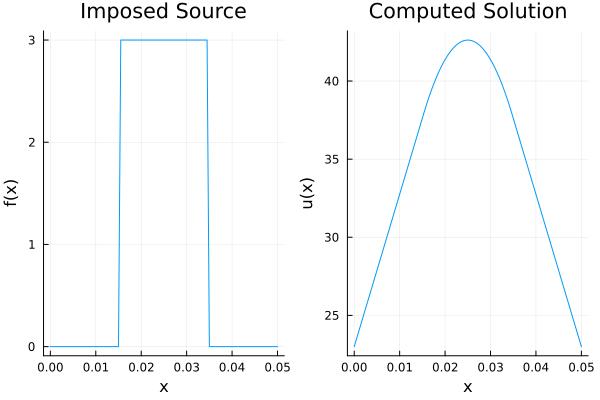

In [3]:
#..construct the mesh 
L = 0.05
nelements = 100; nnodes = nelements+1; h = L/nelements
x = Vector(0:h:L)

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:nelements) 
edges = collect( [i, i+1] for i in 1:nelements) 

#..Set the source function 
fsource(x) = 3*(x>(L/2-L/5))*(x<(L/2+L/5))

#..Initialize local and global matrix and right-hand side value 
floc = zeros(Float64,2, 1)
Aloc = zeros(Float64,2,2)
A = zeros(Float64,nnodes, nnodes)
f = zeros(Float64,nnodes)  

#..Perform loop over elements and assemble global matrix and vector 
for i=1:nelements 

  xl, xr = points[i,:][1]
  floc = (xr-xl)/2 * [fsource(xl), fsource(xr)]
  Aloc = (0.00003*1/(xr-xl))*[1 -1; -1 1]

  for j=1:2 
    f[edges[i][j]] += floc[j]
    for k =1:2 
      A[edges[i][j], edges[i][k]] += Aloc[j,k]
    end 
  end 

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 23
A[end,end-1]=0; A[end,end] = 1;    f[end] = 23

#..solve the linear system
u = A \ f

#..plot the source term 
fplot = fsource.(x)
p1=plot(x,fplot,legend=false)
xlabel!("x") 
ylabel!("f(x)")
title!("Imposed Source")

#..plot the solution  
p2=plot(x,u,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Computed Solution")

plot(p1,p2,layout=(1,2))

###  Section 2.2: Elective: Biharmonic Equation 
Solves the fourth order bi-harmonic equation $u^{4}(x) = f $ supplied with boundary conditions. We use a formulation with a linear system double in size. In this formulation the solution vector u consists of both displacement (udisp) and bending moment (umom).  

In [4]:
xi = Vector(-1.:0.01:1.)

201-element Vector{Float64}:
 -1.0
 -0.99
 -0.98
 -0.97
 -0.96
 -0.95
 -0.94
 -0.93
 -0.92
 -0.91
 -0.9
 -0.89
 -0.88
  ⋮
  0.89
  0.9
  0.91
  0.92
  0.93
  0.94
  0.95
  0.96
  0.97
  0.98
  0.99
  1.0

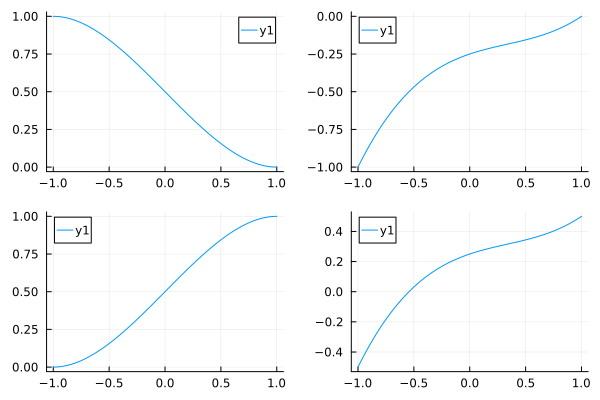

In [5]:
xi = Vector(-1.:0.01:1.)
phi1(xi) = (2 - 3 * xi + xi^3)/4
phi2(xi) = (-1 + xi - xi^2 + xi^3)/4
phi3(xi) = (2 + 3 * xi - xi^3)/4
phi4(xi) = (1 + xi - xi^2 + xi^3)/4

p1 = plot(xi, phi1.(xi))
p2 = plot(xi, phi2.(xi))
p3 = plot(xi, phi3.(xi))
p4 = plot(xi, phi4.(xi))

plot(p1,p2,p3,p4,layout=(2,2))

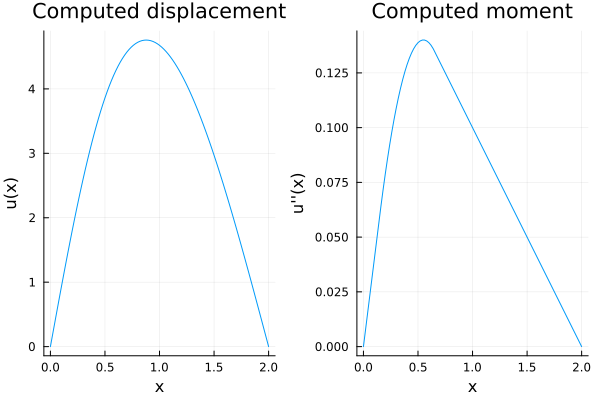

In [6]:
#..construct the mesh 
L = 2
nelements = 100; nnodes = nelements+1; h = L/nelements
x = Vector(0:h:L)

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:nelements) 
edges = collect( [i, i+1] for i in 1:nelements) 

#..Set the source function 
fsource(x) = (x>(L/5-L/8))*(x<(L/5+L/8))
# fsource(x) = 1 

#..Initialize local and global matrix and right-hand side value 
floc = zeros(Float64,2, 1)
Aloc = zeros(Float64,2,2)
A = zeros(Float64,nnodes, nnodes)
f = zeros(Float64,nnodes)  

#..Perform loop over elements and assemble global matrix and vector 
for i=1:nelements 

  xl, xr = points[i,:][1]
  floc = (xr-xl)/2 * [fsource(xl), fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  for j=1:2 
    f[edges[i][j]] += floc[j]
    for k =1:2 
      A[edges[i][j], edges[i][k]] += Aloc[j,k]
    end 
  end 

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0

#..construct linear system of double size 
I   = UniformScaling(nnodes)
nul = 0*I; 
B   = [A -h*I; nul A]
ff  = [0*f; f]

#..solve the linear system
uu = B \ ff 

#..retrieve computed solution 
udisp = uu[1:nnodes]
umom  = uu[nnodes+1:end]

#..plot the solution  
p1=plot(x,udisp,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Computed displacement")

#..plot the solution  
p2=plot(x,umom,legend=false)
xlabel!("x") 
ylabel!("u''(x)")
title!("Computed moment")

plot(p1,p2,layout=(1,2))

## Section 3: One-Dimensional Mesh Generation 

Exercise: extend from uniform to non-uniform mesh with local refinements to capture local variations in the solution (e.g. material interfaces, local features in the geometry, or large gradients near the boundary).  

In [7]:
# struct to hold a single mesh element
# all the members of the struct should be concrete type 
struct Element
  p1::Float64    # coordinate left-most node
  p2::Float64    # coordinate right-most node
  e1::Int64      # global index left-most node
  e2::Int64      # global index right-most node
  area::Float64  # area of the element 
end

# struct to hold entire mesh
struct Mesh
  nnodes::Int64
  nelements::Int64 
  # specify one-dimensional array of elements as an array of structs. 
  # we worry about using structArray (if as all) later. 
  Elements::Array{Element,1}
  bndNodeIds::Vector{Int64}
  dofPerElement::Int64       
end 

In [8]:
# function to generate a mesh on the interval 0 <= x <= 1.   
# we limit the type of input to be Int64 
function genMesh(nelements::Int64)::Mesh
    h = 1/nelements 
    nnodes = nelements+1
    dofPerElement = 2 
    x = Vector{Float64}(0:h:1)    
    # what does the undef do here? 
    Elements = Array{Element,1}(undef,nelements)
    for i in 1:nelements
        Elements[i] = Element(x[i],x[i+1],i,i+1,x[i+1]-x[i])
    end
    mesh = Mesh(nnodes,nelements,Elements,[1,nelements+1],dofPerElement)     
    return mesh;
end 

genMesh (generic function with 1 method)

In [9]:
# test function for correctness of output 
mesh = genMesh(4)
typeof(mesh)

Mesh

In [10]:
# test function for type stability 
# the text under Local @3 in orange font is considered to be harmless 
#@code_warntype genMesh(4);

In [11]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size 
@time genMesh(10);
@time genMesh(100);
@time genMesh(1000);
@time genMesh(10000);

  0.000008 seconds (3 allocations: 720 bytes)
  0.000006 seconds (3 allocations: 5.016 KiB)
  0.000008 seconds (4 allocations: 47.188 KiB)
  0.000030 seconds (5 allocations: 468.984 KiB)


In [12]:
#@code_lowered generateMesh(10)

## Section 4: Linear System Assembly 

### Section 1.4: Assemble Stiffness Matrix 

Note that in the function generateMatrix() given below the variables Iloc, Jloc, Aloc do not require pre-allocation. Declaring these variables instead as static arrays appears to be sufficient to obtain a type stable function.  

In [13]:
# generates local stiffness matrix 
function genLocStiffMat(element::Element)
    h     = element.area 
    e1    = element.e1
    e2    = element.e2
    Iloc  = SVector(e1, e1, e2, e2) 
    Jloc  = SVector(e1, e2, e1, e2) 
    Aloc  = SVector(1/h, -1/h, -1/h, 1/h) 
    return Iloc, Jloc, Aloc
end

# generate global stiffness matrix 
function genStiffMat(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofperelem = 4; 
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, Jloc, Aloc = genLocStiffMat(element) 
        irng = mrange(4*i-3,4*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end

genStiffMat (generic function with 1 method)

In [1]:
mesh = genMesh(10);
#@code_warntype genStiffMat(mesh)

LoadError: UndefVarError: genMesh not defined

In [15]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time genStiffMat(mesh); # force function compilation 
mesh = genMesh(10);    @time genStiffMat(mesh); 
mesh = genMesh(100);   @time genStiffMat(mesh);
mesh = genMesh(1000);  @time genStiffMat(mesh); 
mesh = genMesh(10000); @time genStiffMat(mesh); 

  0.022663 seconds (2.61 k allocations: 116.047 KiB, 93.54% compilation time)
  0.000004 seconds (14 allocations: 3.109 KiB)
  0.000007 seconds (14 allocations: 23.953 KiB)
  0.000042 seconds (21 allocations: 227.844 KiB)
  0.000513 seconds (24 allocations: 2.214 MiB)


In [46]:
# generate global stiffness matrix 
function genStiffMat2(mesh::Mesh)
    
    #..recover number of elements  
    nelements = mesh.nelements
    dofperelem = 4; 
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*nelements)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))
    
    for (i,element) in enumerate(mesh.Elements) #..loop over number of elements..
        Iloc, Jloc, Aloc = genLocStiffMat(element) 
        irng = mrange(4*i-3,4*i) 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc 
    end
    A = sparse(I,J,Avalues)
   
    return A; 
end

genStiffMat2 (generic function with 1 method)

In [47]:
mesh = genMesh(10);
A = genStiffMat2(mesh)
#@code_warntype generateMatrix(mesh)

11×11 SparseMatrixCSC{Float64, Int64} with 31 stored entries:
  10.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
 -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   20.0  -10.0
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -10.0   10.0

### Section 2.4: Assemble Right-Hand Side Vector

In [15]:
fsource(x) = x*(x-1)

function genLocVec(element, sourceFct)
    h = element.area 
    Iloc = SVector(element.e1, element.e2)
    floc = (h/2)*SVector(sourceFct(element.p1), sourceFct(element.p2))
    return Iloc, floc
end

function genVector(mesh, sourceFct::F) where F 
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    f = zeros(Float64,nnodes)

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        Iloc, floc = genLocVec(element,sourceFct) 
        f[Iloc] .+= floc          
    end
   
    return f; 
end

genVector (generic function with 1 method)

In [16]:
#@code_warntype genVector(mesh, fsource)

In [17]:
# observe again how the number of memory allocations only depends midly on the mesh size
mesh = genMesh(10);    @time f = genVector(mesh,fsource); # force function compilation
mesh = genMesh(10);    @time f = genVector(mesh,fsource);
mesh = genMesh(100);   @time f = genVector(mesh,fsource);
mesh = genMesh(1000);  @time f = genVector(mesh,fsource);
mesh = genMesh(10000); @time f = genVector(mesh,fsource);

  0.195031 seconds (770.15 k allocations: 41.741 MiB, 6.62% gc time, 99.98% compilation time)
  0.000003 seconds (1 allocation: 144 bytes)
  0.000003 seconds (1 allocation: 896 bytes)
  0.000004 seconds (1 allocation: 8.000 KiB)
  0.000018 seconds (2 allocations: 78.234 KiB)


## Section 5: Solve Process 

  0.000305 seconds (67 allocations: 552.297 KiB)


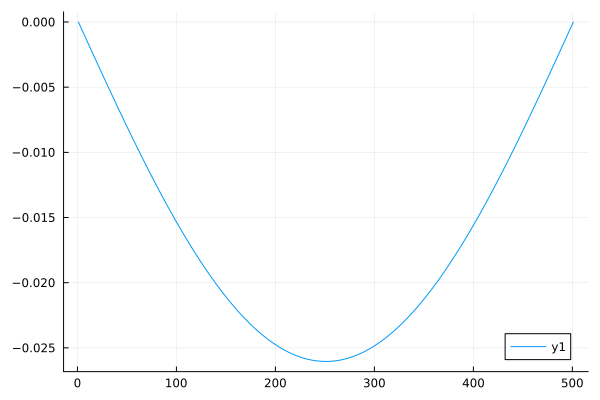

In [20]:
N = 500 
mesh = genMesh(N)

A = genStiffMat(mesh) # force compilation 
f = genVector(mesh,fsource) # force compilation

function genSolution(A,f)
    #..handle essential boundary conditions 
    A[1,1] = 1.; A[1,2] = 0.; f[1] = 0.;
    A[end,end] = 1.; A[end,end-1] = 0.; f[end] = 0.;
    u = A\f 
    return u 
end

u = genSolution(A,f) # force compilation 
@time u = genSolution(A,f)

plot(u)

In [21]:
# observe again how the number of memory allocations only depends midly on the mesh size
# observe how assembly is much faster than the solve 
mesh = genMesh(10);    @time A = genStiffMat(mesh); f = genVector(mesh,fsource); @time u = genSolution(A,f);
mesh = genMesh(100);   @time A = genStiffMat(mesh); f = genVector(mesh,fsource); @time u = genSolution(A,f);
mesh = genMesh(1000);  @time A = genStiffMat(mesh); f = genVector(mesh,fsource); @time u = genSolution(A,f);
mesh = genMesh(10000); @time A = genStiffMat(mesh); f = genVector(mesh,fsource); @time u = genSolution(A,f);

  0.000009 seconds (15 allocations: 3.156 KiB)
  0.000059 seconds (67 allocations: 26.578 KiB)
  0.000014 seconds (15 allocations: 24.000 KiB)
  0.000081 seconds (67 allocations: 124.547 KiB)
  0.000045 seconds (22 allocations: 227.891 KiB)
  0.000362 seconds (69 allocations: 1.061 MiB)
  0.000391 seconds (25 allocations: 2.214 MiB)
  0.004092 seconds (73 allocations: 10.454 MiB)


## Section 6: Computing the Derivative

In [22]:
function genDeriv(mesh, u)
    
    #..recover number of elements  
    nelements = mesh.nelements 
    nnodes = mesh.nnodes 
    
    #..initialize global vector  
    du = zeros(Float64,nelements)

    for i = 1:nelements #..loop over number of elements..
        element = mesh.Elements[i]
        h  = element.area 
        u1 = u[element.e1]
        u2 = u[element.e2]
        du[i] = (u2-u1)/h        
    end
   
    return du
end

genDeriv (generic function with 1 method)

  0.013018 seconds (19.83 k allocations: 1.093 MiB, 99.70% compilation time)


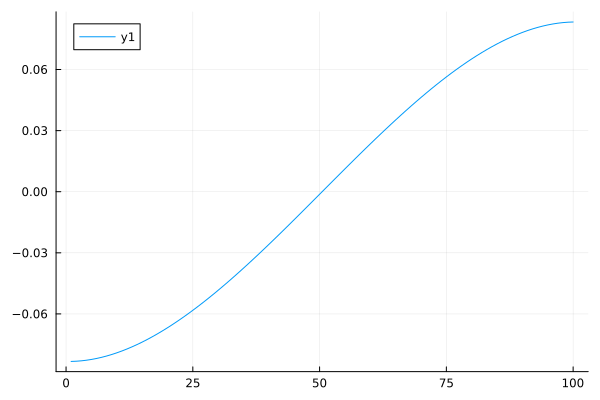

In [23]:
mesh = genMesh(100);   A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f);
@time du = genDeriv(mesh,u); 
plot(du)

In [24]:
mesh = genMesh(10);    A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f); 
@time du = genDeriv(mesh,u); 
mesh = genMesh(100);   A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f);
@time du = genDeriv(mesh,u); 
mesh = genMesh(1000);  A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f);
@time du = genDeriv(mesh,u); 
mesh = genMesh(10000); A = genStiffMat(mesh); f = genVector(mesh,fsource); u = genSolution(A,f);
@time du = genDeriv(mesh,u); 

  0.000008 seconds (1 allocation: 144 bytes)
  0.000004 seconds (1 allocation: 896 bytes)
  0.000006 seconds (1 allocation: 7.938 KiB)
  0.000021 seconds (2 allocations: 78.172 KiB)


## Section 7: Mesh Refinement Study 
Check converge to both $u(x)$ and $du/dx$ as the mesh is refined.  

## Section 8: Variable Diffusion Coefficient 
We change the Poisson equation to ... 

## Section 9: Zeroth Order Derivative and Mass Matrix Term 

## Sandbox